# Boosting
##### Imports

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

from data import get_data

### Data Loading + Preprocessing

In [23]:
ROOT = './tadpole_challenge/'
X, y = get_data(ROOT)
label_dict = {0: 'AD', 1: 'CN', 2: 'EMCI', 3: 'LMCI', 4: 'SMC'}

NameError: name 'get_data' is not defined

##### Split data into Train and Test datasets

In [13]:
# create training and validation datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

### Helper Functions

In [ ]:
def accuracy(clf, X, y):
    y_pred = clf.predict(X)
    acc = sum(y_pred == y) / len(y)
    return acc

In [ ]:
def showConfusionMatrix(clf, X, y):
    cm = confusion_matrix(y, clf.predict(X))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=('Predicted ' + labels_DX_bl[0], 'Predicted ' + labels_DX_bl[1], 'Predicted ' + labels_DX_bl[2], 'Predicted ' + labels_DX_bl[3], 'Predicted ' + labels_DX_bl[4]))
    ax.yaxis.set(ticks=(0, 1, 2, 3, 4), ticklabels=('Actual ' + labels_DX_bl[0], 'Actual ' + labels_DX_bl[1], 'Actual ' + labels_DX_bl[2], 'Actual ' + labels_DX_bl[3], 'Actual ' + labels_DX_bl[4]))
    #ax.set_ylim(1.5, -0.5)
    for i in range(5):
        for j in range(5):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

In [ ]:
def report_accuracy(clf):
    train_acc = accuracy(clf, X_train, y_train)
    test_acc = accuracy(clf, X_test, y_test)
    print('Train accuracy:', train_acc)
    print('Test accuracy:', test_acc)
    showConfusionMatrix(clf, X_test, y_test)

In [ ]:
def evaluate(Classifier, **kwargs):
    print('+ Base learner')
    clf = Classifier(**kwargs).fit(X_train, y_train)
    report_accuracy(clf)
    print('+ Ensemble')
    bag_clf = bagging_clf(Classifier(**kwargs)).fit(X_train, y_train)
    report_accuracy(bag_clf)

In [ ]:
def main():
    baselearners = [DecisionTreeClassifier, 
                    LinearSVC, 
                    MLPClassifier,
                    LogisticRegression]
    
    for learner in baselearners:
        print(learner)
        evaluate(learner)
        print()

### Model Training

#### Train Base Learners

##### Decision Tree

In [14]:
evaluate(DecisionTreeClassifier)

DecisionTreeClassifier()

##### Logistic Regression Analysis (LRA)

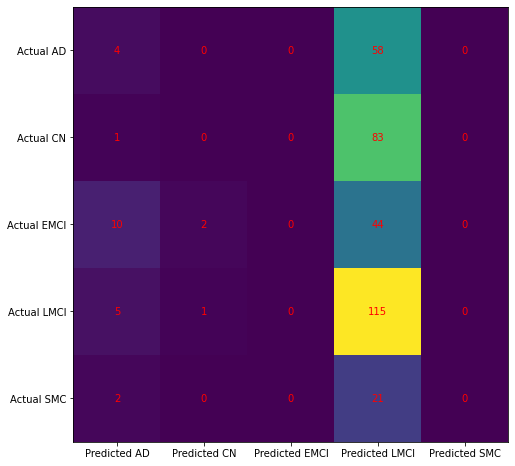

In [19]:
evaluate(LogisticRegression)

##### Artifical Neural Network (ANN)

In [ ]:
evaluate(MLPClassifier)

##### SVM

In [ ]:
evaluate(LinearSVC)

##### All base learners at once

In [ ]:
main()

### Experiment
Repeat 100 times